In [121]:
import pandas as pd
data=pd.read_excel('Folds5x2_pp.xlsx')

data

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


In [122]:
X=data.drop(columns=['PE'])
y=data['PE']
X.info()
y.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
dtypes: float64(4)
memory usage: 299.1 KB


0    463.26
1    444.37
2    488.56
3    446.48
4    473.90
Name: PE, dtype: float64

In [123]:
from sklearn.cluster import KMeans

models={}
labels={}
for col in X.columns:
  model =KMeans(n_clusters=4)
  model.fit(X[[col]])
  centers=model.cluster_centers_.tolist()
  centers=sum(centers,[])
  centers=sorted(centers)
  models[col]=centers
  labels[col]=model.labels_

models

{'AT': [9.057614678899077,
  15.59907052588667,
  22.926249569114095,
  29.07565275310834],
 'V': [41.237095446359646,
  50.04817467248908,
  61.175888450148065,
  70.94096812749004],
 'AP': [1005.7656181818182,
  1011.7219476268413,
  1017.5417611190818,
  1024.3976039387308],
 'RH': [48.80277397260272,
  64.8571790808241,
  77.74031853608946,
  90.03306114698063]}

Sorting clustered data to dataframe

In [124]:
import pandas as pd

X_clust=pd.DataFrame(data=labels)
X_clust.head()

,AT,V,AP,RH
0,0,0,2,0
1,1,3,0,1
2,3,0,3,2
3,1,3,3,0
4,3,0,3,2


In [125]:
model=KMeans(n_clusters=4)
model.fit(y.to_frame())
y_centers=model.cluster_centers_.tolist()
y_centers=sum(y_centers,[])
y_centers=sorted(y_centers)
y_labels=model.labels_

y_centers

[435.47170320404723, 448.78052977571537, 465.4493359545653, 480.45765625]

In [61]:
!pip install fuzzylogic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [126]:
from fuzzylogic.functions import S,R,triangular

def make_fuzzy_set(col_min,col_max,center):
  if col_min==center:
    return S(col_min,col_max)
  elif col_max==center:
    return R(col_min,col_max)
  else:
    return triangular(col_min,col_max,c=center)

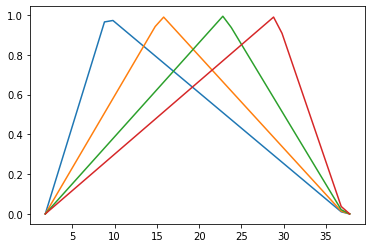

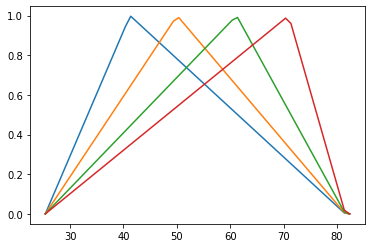

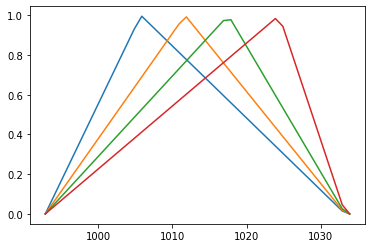

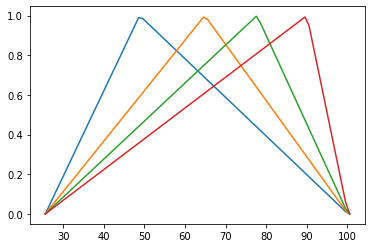

In [127]:
from fuzzylogic.classes import Domain
from matplotlib import pyplot as plt

for key,value in models.items():
  plt.figure()
  X_col=X[key]
  col_min=X_col.min()
  col_max=X_col.max()
  exec(f'{key}=Domain(key,col_min,col_max)')
  for i,rank in enumerate(['low','medium','high','higher']):
    exec(f'{key}.{rank}=make_fuzzy_set(col_min,col_max,value[{i}])')
    exec(f'{key}.{rank}.plot()')

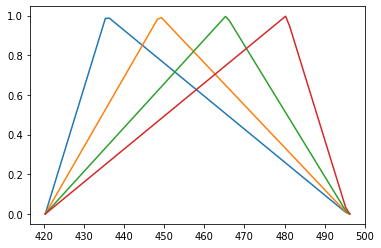

In [128]:
y_min=y.min()
y_max=y.max()
exec(f'{y.name}=Domain(y.name,y_min,y_max)')
for i, rank in enumerate(['low','medium','high','higher']):
  exec(f'{y.name}.{rank}=make_fuzzy_set(y_min,y_max,y_centers[{i}])')
  exec(f'{y.name}.{rank}.plot()')

In [129]:
from sklearn.naive_bayes import MultinomialNB

model=MultinomialNB()
model.fit(X_clust,y_labels)

model.feature_log_prob_

array([[-1.34363861, -1.47995924, -1.26518975, -1.47284341],
       [-1.84501003, -2.23187371, -0.93117128, -1.07717196],
       [-1.8920274 , -1.00022698, -1.2760393 , -1.59801585],
       [-0.64569438, -5.38460427, -1.37857063, -1.51787754]])

In [130]:
from itertools import product

X_comb=[]
for comb in product(*len(X_clust.columns)*[[0,1,2,3]]):
  X_comb.append(comb)
X_comb=pd.DataFrame(X_comb,columns=X_clust.columns)

X_comb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   AT      256 non-null    int64
 1   V       256 non-null    int64
 2   AP      256 non-null    int64
 3   RH      256 non-null    int64
dtypes: int64(4)
memory usage: 8.1 KB


In [131]:
preds = model.predict(X_comb)

preds[:10]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [132]:
data = X_comb.copy()
data['labels'] = preds
data.to_csv('data_and_labels.csv')

In [133]:
map={0:'low',
     1:'medium',
     2:'high',
     3:'higher'}

In [134]:
from fuzzylogic.classes import Rule

rules =[]
for i,row in X_comb.iterrows():
  cond=[]
  for col in X_comb.columns:
    cond.append('.'.join([col,map[row[col]]]))
  cond=', '.join(cond)
  cons='.'.join([y.name,map[preds[i]]])
  rules.append(f'({cond}):{cons}')

rules =eval('Rule({' + ',\n'.join(rules)+',})')

rules

In [135]:
X_test = X[:200]
values=[]
for i,row in X_test.iterrows():
  value={}
  for col in X_test.columns:
    value[eval(col)]=row[col]
  values.append(value)

values[:5]

[{Domain('AT', 1.81, 37.11, res=1, sets={'low': Set(<function triangular.<locals>.f at 0x7f5939c5a310>), 'medium': Set(<function triangular.<locals>.f at 0x7f59396800d0>), 'high': Set(<function triangular.<locals>.f at 0x7f5939680790>), 'higher': Set(<function triangular.<locals>.f at 0x7f5939680ee0>)}): 14.96,
  Domain('V', 25.36, 81.56, res=1, sets={'low': Set(<function triangular.<locals>.f at 0x7f593967dc10>), 'medium': Set(<function triangular.<locals>.f at 0x7f59397fb280>), 'high': Set(<function triangular.<locals>.f at 0x7f59397fb9d0>), 'higher': Set(<function triangular.<locals>.f at 0x7f5939833160>)}): 41.76,
  Domain('AP', 992.89, 1033.3, res=1, sets={'low': Set(<function triangular.<locals>.f at 0x7f5939833e50>), 'medium': Set(<function triangular.<locals>.f at 0x7f5939724550>), 'high': Set(<function triangular.<locals>.f at 0x7f5939724ca0>), 'higher': Set(<function triangular.<locals>.f at 0x7f59397d2430>)}): 1024.07,
  Domain('RH', 25.56, 100.16, res=1, sets={'low': Set(<f

In [136]:
preds=[rules(x) for x in values]

preds[:10]

[455.2875434595629,
 454.9840426635188,
 455.7443544396729,
 455.17364329205293,
 454.9319276683462,
 454.9548133172668,
 455.3358271561675,
 455.6258213179535,
 455.5809317412411,
 455.3843287695196]

In [137]:
y_test=y[:200]
df_test=pd.DataFrame(data={'y_pred':preds,'y_true':y_test})
df_test=df_test.dropna()

df_test

,y_pred,y_true
0,455.287543,463.26
1,454.984043,444.37
2,455.744354,488.56
3,455.173643,446.48
4,454.931928,473.90
...,...,...
195,454.881822,441.93
196,454.416537,432.64
197,455.301246,480.25
198,455.453304,466.68


In [139]:
from sklearn.metrics import mean_squared_error

mse_fuzzy=mean_squared_error(df_test['y_true'],df_test['y_pred'])

print(mse_fuzzy)

269.11297224307964


In [140]:
from sklearn.linear_model import LinearRegression

model=LinearRegression()
model.fit(X,y)
preds=model.predict(X_test)

mse_linear=mean_squared_error(y_test,preds)

print(mse_linear)

18.85831298017789


In [142]:
with open('mse.log', 'w') as l:
  l.write('MSE for fuzzy inference ')
  l.write(str(mse_fuzzy))
  l.write('\n\n')
  l.write('MSE for linear regression ')
  l.write(str(mse_linear))